In [2]:
# 파일 확인 ( ls 명령어 사용 )

%%bash
ls -l drive/MyDrive/Colab\ Notebooks/data-files


total 831682
-rw------- 1 root root     30286 May 22  2023 auto-mpg.data
-rw------- 1 root root     32149 May 22  2023 auto-mpg.data-original
-rw------- 1 root root      1660 May 22  2023 auto-mpg.names
-rw------- 1 root root 851576689 Dec 11 02:57 dogs-vs-cats.zip
-rw------- 1 root root       161 May 22  2023 Index


In [3]:
# 파일 복사 ( gooogle driver -> sample_date)

%%bash
cp drive/MyDrive/Colab\ Notebooks/data-files/dogs-vs-cats.zip sample_data/

In [4]:
# 압축 풀기

%%bash
mkdir sample_data/dogs-vs-cats
unzip sample_data/dogs-vs-cats.zip -d sample_data/dogs-vs-cats

Archive:  sample_data/dogs-vs-cats.zip
  inflating: sample_data/dogs-vs-cats/sampleSubmission.csv  
  inflating: sample_data/dogs-vs-cats/test1.zip  
  inflating: sample_data/dogs-vs-cats/train.zip  


In [5]:
# 압축 풀기 2 (하위 폴더의 train.zip, test1.zip 파일 압축 해제)

%%bash
unzip sample_data/dogs-vs-cats/train.zip -d sample_data/dogs-vs-cats
unzip sample_data/dogs-vs-cats/test1.zip -d sample_data/dogs-vs-cats



Output hidden; open in https://colab.research.google.com to view.

In [6]:
# 폴더명 변경

%%bash
mv sample_data/dogs-vs-cats/test1 sample_data/dogs-vs-cats/test

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras as tf_keras

In [8]:
# 데이터 딕렉토리 구성
# train_dir, test_dir, validation_dir # 훈련, 테스트, 검증 세트 폴드
# train_dir =:cats, dogs # 범주로 사용될 폴더
# test_dir -> cats, doogs
# validation_dir -> cats, dogs

import os, shutil

src_base = 'sample_data/dogs-vs-cats'
dest_base = 'sample_data/dogs-vs-cats2'

if os.path.exists(dest_base):  # 이미 존재하는 폴더라면
  shutil.rmtree(dest_base)     # 폴더 제거 후
os.mkdir(dest_base)            # 새로 폴더 만들기

# train 폴더의 0 ~ 1000 : trainset, 1000 ~ 1500 : validationset, 1500 ~ 2000 : testset
for start, stop, path in zip([0, 1000, 1500], [1000, 1500, 2000], ['train', 'validation', 'test']):
  os.mkdir(os.path.join(dest_base, path)) # train or validation or test 폴더 생성
  for sub_path in ['cat', 'dog']:
    os.mkdir(os.path.join(dest_base, path, sub_path)) # train, validation, test 하위에 cats or dog 폴더 생성
    for idx in np.arange(start, stop):
      fname = f'{sub_path}.{idx}.jpg'
      shutil.copy(os.path.join(src_base, 'train', fname), os.path.join(dest_base, path, sub_path, fname))

In [9]:
# 디렉토리 구성 결과 확인
for path in ['train', 'validation', 'test']:
  for subpath in ['cat', 'dog']:
    print(path, '/', subpath, ':', len(os.listdir(f'sample_data/dogs-vs-cats2/{path}/{subpath}')))

train / cat : 1000
train / dog : 1000
validation / cat : 500
validation / dog : 500
test / cat : 500
test / dog : 500


In [10]:
# 입력 자동화 도구 만들기

# 특정 디렉터리의 파일을 읽어서 모델의 입력데이터로 변환하는 도구
train_generator = tf_keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
validation_generator = tf_keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_generator = tf_keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

In [11]:
# 입력 데이터 구성

datasets = []
for path, generator in zip(['train', 'test', 'validation'],
                [train_generator, test_generator, validation_generator]):
  dataset = generator.flow_from_directory(directory=f'sample_data/dogs-vs-cats2/{path}',
                                target_size=(256, 256),
                                batch_size=32,
                                class_mode='binary')
  datasets.append(dataset)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
print( type(datasets[0]) )
for X_batch, y_batch in datasets[0]:
  print(X_batch.shape, y_batch.shape)
  print(X_batch[0].max())
  print(y_batch)
  break

<class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>
(32, 256, 256, 3) (32,)
1.0
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1.
 0. 1. 1. 0. 0. 1. 1. 0.]


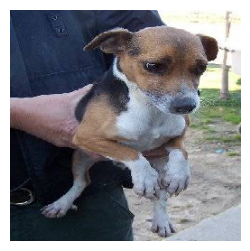

In [13]:
plt.figure(figsize=(3, 3))
plt.imshow(X_batch[2])
plt.axis('off')
plt.show()

In [14]:
# 이미 만들어진 모델 가져오기 1

base_model = tf_keras.applications.vgg16.VGG16()

base_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# 이미 만들어진 모델 가져오기 2 ( 최상위 판별층 제외 )

base_model = tf_keras.applications.vgg16.VGG16(include_top=False,
                                               weights='imagenet',
                                               input_shape=(256, 256, 3))

base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

<class 'numpy.ndarray'> (256, 256, 3)
(1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
(1, 8, 8, 512)


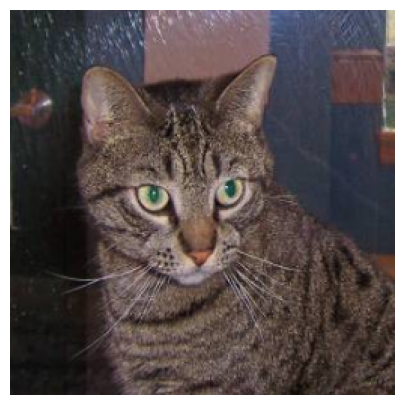

In [16]:
import cv2

cat_img = cv2.imread('sample_data/dogs-vs-cats/train/cat.1.jpg', cv2.IMREAD_COLOR) # BGR
cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB) # BGR -> RGB
cat_img = cv2.resize(cat_img, (256, 256))

print(type(cat_img), cat_img.shape)

Input = cat_img.reshape(-1, 256, 256, 3) / 255.0   # (배치크기, 이미지데이터_shape)
print(Input.shape)

predicted_value = base_model.predict(Input)        # 사전학습모델을 통해 만든 특성맵 도출
print(predicted_value.shape)

plt.figure(figsize=(5, 5))
plt.imshow(cat_img)
plt.axis('off')
plt.show()




In [21]:
# 입력 데이터 -> 사전 학습 모델 -> 특성 맵 : 이 특성맵을 신규개발모델의 입력으로 사용
def get_feature_map_by_vgg16_base_model(dataset, cnt):
  all_features = []
  all_labels = []
  for idx, (X_batch, y_batch) in enumerate(dataset):
    features = base_model.predict(X_batch)

    all_features.append(features)
    all_labels.append(y_batch)

    if cnt <= idx:
      break

  return np.concatenate(all_features), np.concatenate(all_labels)

In [22]:
train_features, train_labels = get_feature_map_by_vgg16_base_model(datasets[0], 100)
validation_features, validation_labels = get_feature_map_by_vgg16_base_model(datasets[2], 50)
test_features, test_labels = get_feature_map_by_vgg16_base_model(datasets[1], 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [23]:
train_features.shape, validation_features.shape, test_features.shape

((3216, 8, 8, 512), (1608, 8, 8, 512), (1608, 8, 8, 512))

In [24]:
# 모델 구조 설계 ( 사전 학습 모델을 통해 만든 특성맵 데이터를 입력으로 사용하는 판별 모델 )

# discriminative_model = tf_keras.models.Sequential([
#     tf_keras.layers.Input(shape=train_features.shape[1:]),  # # train_features.shape[1:] = (8, 8, 512)
#     tf_keras.layers.Flatten(),
#     tf_keras.layers.Dense(256, activation='relu'),
#     tf_keras.layers.Dense(1, activation='sigmoid')
#  ])

input = tf_keras.layers.Input(shape=train_features.shape[1:])
x = tf_keras.layers.Flatten()(input)
x = tf_keras.layers.Dense(256, activation='relu')(x)
output = tf_keras.layers.Dense(1, activation='sigmoid')(x)
discriminative_model = tf_keras.models.Model(inputs=input, outputs=output)

discriminative_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,389,121 (32.00 MB)

 Trainable params: 8,389,121 (32.00 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# 모델 학습 설계 ( 사전 학습 모델을 통해 만든 특성맵 데이터를 입력으로 사용하는 판별 모델 )

discriminative_model.compile(loss='binary_crossentropy',
                                           optimizer='adam',
                                           metrics=['accuracy'])

In [26]:
# 판별 모델 학습

fit_history = discriminative_model.fit(train_features, train_labels,
                                        epochs=20,
                                        validation_data=(validation_features, validation_labels))

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7369 - loss: 1.2633 - val_accuracy: 0.9086 - val_loss: 0.2417
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9337 - loss: 0.1445 - val_accuracy: 0.9042 - val_loss: 0.2521
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9928 - loss: 0.0289 - val_accuracy: 0.9086 - val_loss: 0.2591
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9994 - loss: 0.0120 - val_accuracy: 0.9223 - val_loss: 0.2176
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.9266 - val_loss: 0.2176
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9235 - val_loss: 0.2207
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9229 - val_loss: 0.2322
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0

In [28]:
print( discriminative_model.evaluate(train_features, train_labels) )
print( discriminative_model.evaluate(test_features, test_labels) )

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.9652e-04
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9202 - loss: 0.2635


[0.2850668132305145, 0.913557231426239]

In [29]:
print( fit_history.history.keys() )

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


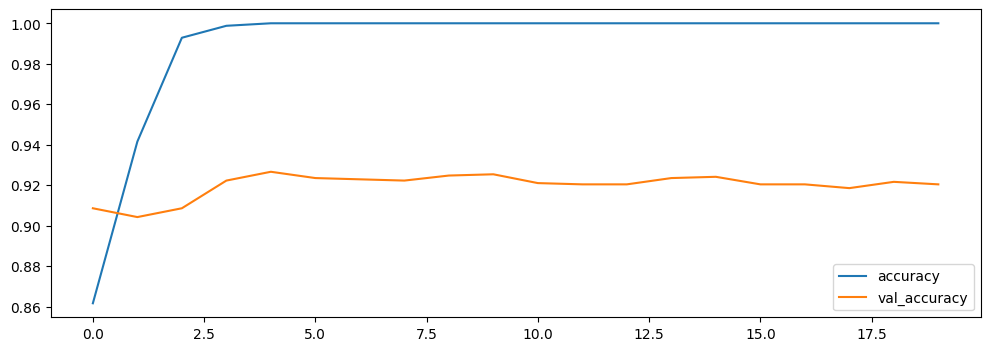

In [30]:
plt.figure(figsize=(12, 4))
plt.plot(fit_history.epoch, fit_history.history['accuracy'], label="accuracy")
plt.plot(fit_history.epoch, fit_history.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()